# Semantic search in business news

This notebook implements semantic search in [news](https://www.kaggle.com/datasets/rmisra/news-category-dataset) articles. 
The dataset is filtered for news in the 'BUSINESS' category.

We are embedding
- headlines
- news body (short description)
- and date
  
to be able to search for
- notable events, or
- related articles to a specific story.

There is a possibility to skew the results towards older or fresher news,
and also to influence the results using a specific search term.

## Boilerplate

### Installation

In [1]:
%pip install superlinked==16.1.0

### Imports and constants

In [2]:
from datetime import datetime, timedelta, timezone

import os
import sys
import altair as alt
import pandas as pd
from superlinked import framework as sl

alt.renderers.enable(sl.get_altair_renderer())
alt.data_transformers.disable_max_rows()
pd.set_option("display.max_colwidth", 190)

In [3]:
YEAR_IN_DAYS = 365
TOP_N = 10
DATASET_URL = "https://storage.googleapis.com/superlinked-notebook-news-dataset/business_news.json"
# as the dataset contains articles from 2022 and before, we can set our application's "NOW" to this date
END_OF_2022_TS = int(datetime(2022, 12, 31, 23, 59).timestamp())
EXECUTOR_DATA = {sl.CONTEXT_COMMON: {sl.CONTEXT_COMMON_NOW: END_OF_2022_TS}}

## Prepare & explore dataset

In [4]:
NROWS = int(os.getenv("NOTEBOOK_TEST_ROW_LIMIT", str(sys.maxsize)))
business_news = pd.read_json(DATASET_URL, convert_dates=True).head(NROWS)

In [5]:
# we are going to need an id column
business_news = business_news.reset_index().rename(columns={"index": "id"})
# let's create utc timestamps
business_news["date"] = [
    int(date.replace(tzinfo=timezone.utc).timestamp()) for date in business_news.date
]

In [6]:
# a sneak peak into the data
business_news.head()

id  \
0  162   
1  353   
2  632   
3  690   
4  727   

                                                                                                     link  \
0              https://www.huffpost.com/entry/rei-workers-berkeley-store-union_n_6307a5f4e4b0f72c09ded80d   
1               https://www.huffpost.com/entry/twitter-elon-musk-trial-october_n_62d7c115e4b000da23f9c7df   
2  https://www.huffpost.com/entry/starbucks-leaves-russian-market-shuts-stores_n_628b9804e4b05cfc268f4413   
3                      https://www.huffpost.com/entry/coinbase-crypto-slumping_n_627c5582e4b0b74b0e7ed621   
4                     https://www.huffpost.com/entry/us-april-jobs-report-2022_n_627517dfe4b009a811c295ec   

                                                                       headline  \
0       REI Workers At Berkeley Store Vote To Unionize In Another Win For Labor   
1  Twitter Lawyer Calls Elon Musk 'Committed Enemy' As Judge Sets October Trial   
2                         Starbucks Leaving Russian Market, Shutting 130 Stores   
3                         Crypto Crash Leaves Trading Platform Coinbase Slumped   
4                      US Added 428,000 Jobs In April Despite Surging Inflation   

   category  \
0  BUSINESS   
1  BUSINESS   
2  BUSINESS   
3  BUSINESS   
4  BUSINESS   

                                                                                                                                         short_description  \
0                                                       They follow in the footsteps of REI workers in New York City who formed a union earlier this year.   
1  Delaware Chancery Judge Kathaleen McCormick dealt the world's richest person a setback in ordering a speedy trial on his abandoned deal to buy Twitter.   
2                                                                               Starbucks' move follows McDonald's exit from the Russian market last week.   
3                                                                       Cryptocurrency trading platform Coinbase has lost half its value in the past week.   
4                                                                                 At 3.6%, unemployment nearly reached the lowest level in half a century.   

              authors        date  
0       Dave Jamieson  1661385600  
1      Marita Vlachou  1658275200  
2  DEE-ANN DURBIN, AP  1653264000  
3        Matt Ott, AP  1652313600  
4    Paul Wiseman, AP  1651795200

### Understand release date distribution

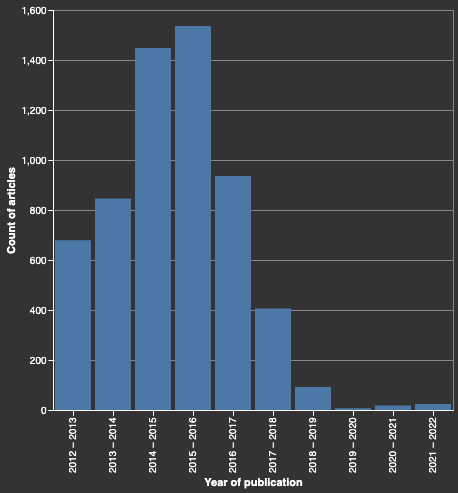

In [7]:
# some quick transformations and an altair histogram
years_to_plot: pd.DataFrame = pd.DataFrame(
    {
        "year_of_publication": [
            int(datetime.fromtimestamp(ts).year) for ts in business_news["date"]
        ]
    }
)
alt.Chart(years_to_plot).mark_bar().encode(
    alt.X("year_of_publication:N", bin=True, title="Year of publication"),
    y=alt.Y("count()", title="Count of articles"),
).properties(width=400, height=400)

The largest period time should be around 11 years as the oldest article is from 2012.

As most articles are between 2012-2017, therefore, it also makes sense to differentiate across the relatively scarce recent period of 4 years.

It can also make sense to give additional weight to more populous time periods - small differences can be amplified by adding extra weight compared to regions where the data is scarce and differences are larger on average.

## Set up Superlinked

In [8]:
# set up schema to accommodate our inputs
class NewsSchema(sl.Schema):
    description: sl.String
    headline: sl.String
    release_timestamp: sl.Timestamp
    id: sl.IdField

In [9]:
news = NewsSchema()

In [10]:
# textual characteristics are embedded using a sentence-transformers model
description_space = sl.TextSimilaritySpace(
    text=news.description, model="sentence-transformers/all-mpnet-base-v2"
)
headline_space = sl.TextSimilaritySpace(
    text=news.headline, model="sentence-transformers/all-mpnet-base-v2"
)
# release date is encoded using our recency embedding algorithm
recency_space = sl.RecencySpace(
    timestamp=news.release_timestamp,
    period_time_list=[
        sl.PeriodTime(timedelta(days=4 * YEAR_IN_DAYS), weight=1),
        sl.PeriodTime(timedelta(days=11 * YEAR_IN_DAYS), weight=2),
    ],
    negative_filter=0.0,
)

In [11]:
# we create an index of our spaces
news_index = sl.Index(spaces=[description_space, headline_space, recency_space])

In [12]:
# simple query will serve us right when we simply want to search the dataset with a search term
# the term will search in both textual fields
# and we will have to option to weight certain inputs' importance
simple_query = (
    sl.Query(
        news_index,
        weights={
            description_space: sl.Param("description_weight"),
            headline_space: sl.Param("headline_weight"),
            recency_space: sl.Param("recency_weight"),
        },
    )
    .find(news)
    .similar(description_space, sl.Param("query_text"))
    .similar(headline_space, sl.Param("query_text"))
    .limit(sl.Param("limit"))
)

# news query on the other hand will search in the database with the vector of a news article
# weighting possibility is still there
news_query = (
    sl.Query(
        news_index,
        weights={
            description_space: sl.Param("description_weight"),
            headline_space: sl.Param("headline_weight"),
            recency_space: sl.Param("recency_weight"),
        },
    )
    .find(news)
    .with_vector(news, sl.Param("news_id"))
    .limit(sl.Param("limit"))
)

In [13]:
dataframe_parser = sl.DataFrameParser(
    schema=news,
    mapping={news.release_timestamp: "date", news.description: "short_description"},
)

In [14]:
source: sl.InMemorySource = sl.InMemorySource(news, parser=dataframe_parser)
executor: sl.InMemoryExecutor = sl.InMemoryExecutor(
    sources=[source], indices=[news_index], context_data=EXECUTOR_DATA
)
app: sl.InMemoryApp = executor.run()

In [15]:
source.put([business_news])

## Understanding recency

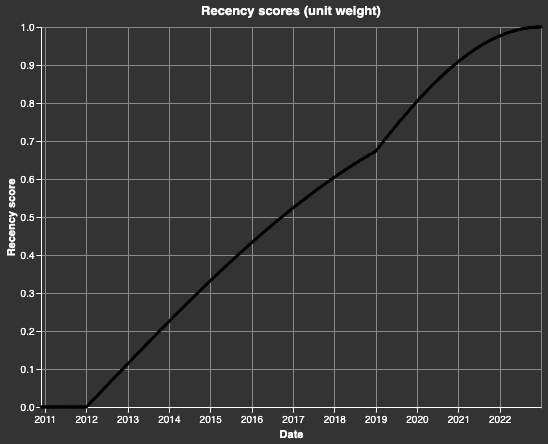

In [16]:
recency_plotter = sl.RecencyPlotter(recency_space, context_data=EXECUTOR_DATA)
recency_plotter.plot_recency_curve()

## Queries

In [17]:
# quick helper to present the results in a notebook
def present_result(
    result_to_present: sl.Result,
    cols_to_keep: list[str] | None = None,
) -> pd.DataFrame:
    if cols_to_keep is None:
        cols_to_keep = [
            "description",
            "headline",
            "release_date",
            "id",
            "similarity_score",
        ]
    # parse result to dataframe
    df: pd.DataFrame = result_to_present.to_pandas()
    # transform timestamp back to release year. Ts is in milliseconds originally hence the division
    df["release_date"] = [
        datetime.fromtimestamp(timestamp, tz=timezone.utc).date()
        for timestamp in df["release_timestamp"]
    ]
    return df[cols_to_keep]

Let's search for one of the biggest acquisitions of the last decade! We are going to set recency's weight to 0 as it does not matter at this point.

In [18]:
result = app.query(
    simple_query,
    query_text="Microsoft acquires LinkedIn",
    description_weight=1,
    headline_weight=1,
    limit=TOP_N,
)

present_result(result)

description  \
0                                                                                      (Reuters) - Microsoft Corp  agreed to buy LinkedIn Corp  for $26.2 billion in cash, the companies said in   
1  Without question, LinkedIn has forever altered the business landscape -- both digitally and in the physical world. Nowadays, so much of what we call business or career development is car...   
2  LinkedIn works very well for the millions of people who make the effort to understand how to leverage it effectively. And those people are very likely not spending more than fifteen a mi...   
3   Although under-used by average LinkedIn members, LinkedIn Groups can be critical to a successful job search because they enable you to communicate directly with recruiters. And vice versa.   
4                                                                   NEW YORK (AP) — Anthem is buying rival Cigna for $48 billion in a deal that would create the nation's largest health insurer   
5                                                                                                                                          The struggling social network is looking for a buyer.   
6                                                                                                      The company's value has soared in the last five years and it has more users than Twitter.   
7                                                                      If failed corporate mergers teach us anything about business, it's that bigger is not always better. Yep, with a 70 to 90   
8                                                                    “With the Snap investment, we have invested over $1.5 billion in promising digital businesses in the last eighteen months.”   
9                                                                Another day, another merger. Telephone companies, drug companies, drugstores, airlines, hospitals, retail stores and beer. Why?   

                                                             headline  \
0              Microsoft Agrees To Acquire LinkedIn For $26.2 Billion   
1                                              The LinkedIn of Things   
2  The 7 LinkedIn Job Search Mistakes That Might Be Costing You a Job   
3                      Get LinkedIn to Recruiters for Your Job Search   
4                    MEGA-MERGER: Anthem To Buy Cigna For $54 Billion   
5     Twitter Is Reportedly In Sales Talks With Google And Salesforce   
6                   Snapchat Is Reportedly Planning A $25 Billion IPO   
7                                      9 Mergers That Epically Failed   
8       NBCUniversal Invested $500 Million In Snap Inc As Part Of IPO   
9                            The Great Remix: Why Mergers Are Booming   

  release_date      id  similarity_score  
0   2016-06-13   64890          1.077354  
1   2015-01-06  110756          0.645348  
2   2014-06-26  127772          0.517061  
3   2014-07-07  126794          0.448696  
4   2015-07-24   93451          0.424201  
5   2016-09-23   55880          0.399515  
6   2016-10-06   54727          0.397601  
7   2013-02-23  173078          0.395794  
8   2017-03-03   41556          0.384653  
9   2015-11-01   84610          0.384269

The first result is about the deal, others are related to some aspect of the query. Let's try upweighting recency to see a recent big acquisition jump to the second place.

In [19]:
result = app.query(
    simple_query,
    query_text="Microsoft acquires LinkedIn",
    description_weight=1,
    headline_weight=1,
    recency_weight=1,
    limit=TOP_N,
)

present_result(result)

description  \
0                                                                                      (Reuters) - Microsoft Corp  agreed to buy LinkedIn Corp  for $26.2 billion in cash, the companies said in   
1                                               “My offer is my best and final offer and if it is not accepted, I would need to reconsider my position as a shareholder,” Musk said in a filing.   
2                                                                                                                     Starbucks' move follows McDonald's exit from the Russian market last week.   
3  Without question, LinkedIn has forever altered the business landscape -- both digitally and in the physical world. Nowadays, so much of what we call business or career development is car...   
4                                        Delaware Chancery Judge Kathaleen McCormick dealt the world's richest person a setback in ordering a speedy trial on his abandoned deal to buy Twitter.   
5                            The decision comes as surging oil prices have been rattling global markets and after Ukraine’s foreign minister criticized Shell for continuing to buy Russian oil.   
6                                                                                                           That makes seven Starbucks stores that have voted to unionize in a matter of months.   
7                                                                                  Recent statements by CEO Howard Schultz offer a glimpse of some of the hardball tactics that might lay ahead.   
8                                                          Android creator Andy Rubin, accused of sexual harassment, was given a severance package worth $240 million, according to the lawsuit.   
9                                                                                                The store in Arizona joins two in New York as the only corporate Starbucks stores with a union.   

                                                                                  headline  \
0                                   Microsoft Agrees To Acquire LinkedIn For $26.2 Billion   
1                                                  Elon Musk Offers To Buy 100% Of Twitter   
2                                    Starbucks Leaving Russian Market, Shutting 130 Stores   
3                                                                   The LinkedIn of Things   
4             Twitter Lawyer Calls Elon Musk 'Committed Enemy' As Judge Sets October Trial   
5                                  Shell Says It Will Stop Buying Russian Oil, Natural Gas   
6                                          Starbucks Workers In Seattle Vote To Form Union   
7            For The Starbucks Union Campaign, A Bruising Contract Fight Is Just Beginning   
8  Google's Alphabet Settles With Shareholders Over Payoffs To Execs Accused Of Harassment   
9                                                Another Starbucks Store Votes To Unionize   

  release_date      id  similarity_score  
0   2016-06-13   64890          0.744528  
1   2022-04-14     849          0.531719  
2   2022-05-23     632          0.490161  
3   2015-01-06  110756          0.462345  
4   2022-07-20     353          0.455939  
5   2022-03-08    1054          0.452028  
6   2022-03-23     967          0.449441  
7   2022-04-16     837          0.438459  
8   2020-09-26    4025          0.426010  
9   2022-02-25    1117          0.425770

Subsequently we can also search with the news article about Elon Musk offering to buy Twitter. As the dataset is quite biased towards old articles, what we get back is news about either Elon Musk or Twitter.

In [20]:
result = app.query(
    news_query,
    description_weight=1,
    headline_weight=1,
    news_id="849",
    limit=TOP_N,
)

present_result(result)

description  \
0                                               “My offer is my best and final offer and if it is not accepted, I would need to reconsider my position as a shareholder,” Musk said in a filing.   
1                                                              The U.S. Securities and Exchange Commission filed a motion asking for the Tesla CEO to show why he shouldn't be held in contempt.   
2                                                                                                                                                                        Don't bet against Musk.   
3                                                                                                                                                           Elon Musk's empire is consolidating.   
4                                                                                               The billionaire wants to marry Tesla and SolarCity. But he says SpaceX should remain a bachelor.   
5                                                                                                                                                The interim CEO purchased 31,000 shares Monday.   
6                                                                                                                     Tesla's CEO says hiring self-driving engineers is "a super high priority."   
7                                                                                                                    Time Warner rejected an $80 billion offer from a different company in 2014.   
8  It's an Elon Musk world, and we're just living in it. Before we bow down to a seemingly fearless and altruistic pioneer of electric vehicles and libertarianism, it's important to point o...   
9                                                                                                                       This could all be part of the secret sauce known as the "Musk Doctrine."   

                                                                   headline  \
0                                   Elon Musk Offers To Buy 100% Of Twitter   
1                   SEC Says Elon Musk Violated Fraud Settlement With Tweet   
2     Why Elon Musk’s Plan To Merge Tesla With SolarCity Will Probably Work   
3                 Tesla Is Buying Sister Company SolarCity For $2.6 Billion   
4                       The One Company Elon Musk Wants To Keep Independent   
5  Jack Dorsey Bought A Bunch Of Twitter Shares, And It's Working Out Great   
6           Elon Musk Just Dropped Another Hint That Tesla May Take On Uber   
7                              AT&T Agrees To Buy Time Warner, In Principle   
8                                 Elon Musk Is Even Smarter Than We Thought   
9    Wall Street Doesn’t Believe Elon Musk Can Produce 500,000 Cars By 2018   

  release_date      id  similarity_score  
0   2022-04-14     849          1.224745  
1   2019-02-26    7191          0.589027  
2   2016-08-16   59220          0.561913  
3   2016-08-01   60483          0.537954  
4   2016-08-04   60237          0.531853  
5   2015-08-10   91958          0.522972  
6   2015-11-20   82841          0.521404  
7   2016-10-21   53309          0.498446  
8   2014-06-14  128870          0.496092  
9   2016-05-09   67933          0.484392

That we can start biasing towards recency, navigating the tradeoff of letting less connected but recent news into the mix. 

In [21]:
result = app.query(
    news_query,
    description_weight=1,
    headline_weight=1,
    recency_weight=1,
    news_id="849",
    limit=TOP_N,
)

present_result(result)

description  \
0                     “My offer is my best and final offer and if it is not accepted, I would need to reconsider my position as a shareholder,” Musk said in a filing.   
1              Delaware Chancery Judge Kathaleen McCormick dealt the world's richest person a setback in ordering a speedy trial on his abandoned deal to buy Twitter.   
2                                    The U.S. Securities and Exchange Commission filed a motion asking for the Tesla CEO to show why he shouldn't be held in contempt.   
3                                                        Recent statements by CEO Howard Schultz offer a glimpse of some of the hardball tactics that might lay ahead.   
4  The decision comes as surging oil prices have been rattling global markets and after Ukraine’s foreign minister criticized Shell for continuing to buy Russian oil.   
5                                                                                                                                              Don't bet against Musk.   
6                                Android creator Andy Rubin, accused of sexual harassment, was given a severance package worth $240 million, according to the lawsuit.   
7                                                                                           Starbucks' move follows McDonald's exit from the Russian market last week.   
8                                                                                                                                 Elon Musk's empire is consolidating.   
9                                                                     The billionaire wants to marry Tesla and SolarCity. But he says SpaceX should remain a bachelor.   

                                                                                  headline  \
0                                                  Elon Musk Offers To Buy 100% Of Twitter   
1             Twitter Lawyer Calls Elon Musk 'Committed Enemy' As Judge Sets October Trial   
2                                  SEC Says Elon Musk Violated Fraud Settlement With Tweet   
3            For The Starbucks Union Campaign, A Bruising Contract Fight Is Just Beginning   
4                                  Shell Says It Will Stop Buying Russian Oil, Natural Gas   
5                    Why Elon Musk’s Plan To Merge Tesla With SolarCity Will Probably Work   
6  Google's Alphabet Settles With Shareholders Over Payoffs To Execs Accused Of Harassment   
7                                    Starbucks Leaving Russian Market, Shutting 130 Stores   
8                                Tesla Is Buying Sister Company SolarCity For $2.6 Billion   
9                                      The One Company Elon Musk Wants To Keep Independent   

  release_date     id  similarity_score  
0   2022-04-14    849          0.995969  
1   2022-07-20    353          0.561419  
2   2019-02-26   7191          0.551953  
3   2022-04-16    837          0.491081  
4   2022-03-08   1054          0.475399  
5   2016-08-16  59220          0.469284  
6   2020-09-26   4025          0.467169  
7   2022-05-23    632          0.465540  
8   2016-08-01  60483          0.455003  
9   2016-08-04  60237          0.451930